# Stima Rt e previsioni

> Max Pierini, Sandra Mazzoli, Alessio Pamovio

***

Il modello di previsione dei nuovi casi può fallire nei seguenti casi:

- _Eventi o interventi atti a diminuire drasticamente il tasso di trasmissione_ (lockdown, zone rosse, rinforzo delle norme di igiene e sicurezza, ecc). In questo caso $R_t$ osservato, e di conseguenza il numero di nuovi casi, potrebbero risultare inferiori al miglior scenario previsto.
- _Eventi o situazioni in grado di aumentare drasticamente il tasso di trasmissione_ (grandi assembramenti, netta riduzione della conformità alle norme di igiene e sicurezza, riapertura scuole e università, ecc). In questo caso $R_t$ osservato, e di conseguenza il numero di nuovi casi, potrebbero risultare superiori al peggior scenario previsto.
- _Interventi atti ad aumentare il numero di test (tamponi) effettuati sulla popolazione_. In questo caso il Tasso di Posività osservato potrebbe risultare inferiore al miglior scenario previsto.
- _Decisioni atte a diminuire il numero di test (tamponi) effettuati sulla popolazione_. In questo caso il Tasso di Posività osservato potrebbe risultare superiore al peggior scenario previsto.

In ogni caso, l'osservazione di un numero di nuovi casi e/o di un Tasso di Positività

- **inferiori al miglior scenario previsto** è una buona indicazione della resa degli interventi di contenimento eventualmente attuati
- **superiori al peggior scenario previsto** è una buona indicazione del fallimento degli interventi di contenimento eventualmente attuati e/o una chiara indicazione a considerare un rinforzo degli interventi in atto o l'introduzione di interventi più efficaci

> NB: gli $R_t$ stimati da EpiDataItalia sono parametrizzati attualmente sui <u>soli nuovi casi</u> riportati al [Dipartimento di Protezione Civile](https://github.com/pcm-dpc/COVID-19) e **non sono sovrapponibili al numero di riproduzione stimato da ISS-EpiCentro** che utilizza lo stesso modello *EpiEstim* ([A new framework and software to estimate time-varying reproduction numbers during epidemics, Cori-Ferguson-Fraser 2013](https://doi.org/10.1093/aje/kwt133)) ma con dati aggiuntivi attualmente **non disponibili al pubblico** (il numero di casi sintomatici con data di inizio sintomi, il numero di casi sintomatici importati da un’altra regione o dall’estero). Per info sul modello in uso da ISS-EpiCentro consultare la pagina [FAQ sul calcolo del Rt](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt) di ISS. Per chiedere al Governo l'accesso pubblico a tutti i dati grezzi disaggregati di COVID-19 in Italia consigliamo l'adesione alla **[Petizione DatiBeneComune](https://datibenecomune.it)**.

***

Modelli utilizzati:

- stima di Rt: EpiEstim Cori et al. (ref: [Package ‘EpiEstim’](https://cran.r-project.org/web/packages/EpiEstim/EpiEstim.pdf), [Cori et al. 2013](https://academic.oup.com/aje/article/178/9/1505/89262))
    - implementato con Markov chain Monte Carlo in `JAGS` e corretto per ignorare incidenze inferiori a una soglia stabilita nella finestra temporale scelta. Finestra 14 giorni, soglia minima 50 nuovi casi
- previsioni: Bettencourt-Ribeiro (ref: [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185#s5))
    - implementato con Markov chain Monte Carlo in `JAGS`. Scenari con Rt stabile e incremento/decremento del 33% su finestra temporale scelta di 14 giorni
- Distribuzione di intervallo di generazione Cereda-Tirani et al. (ref: [Cereda-Tirani 2020](arXiv:2003.09320))

In [1]:
import datetime as dt
import json
import numpy as np
import pandas as pd
import scipy.stats as sps
import pyjags
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown
sns.set()

In [2]:
adapt = 100
warmup = 500
sample = 500

In [3]:
start = dt.datetime.now()
print(f"START: {start}")

START: 2020-11-16 23:41:54.202635


In [4]:
ISS_sh = 1.87
ISS_ra = 0.28

In [5]:
def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

In [6]:
def generation_time_gamma(sh, ra, plot=True, title='Estimated'):

    dist = sps.gamma(a=sh, scale=1/ra)

    max_x = int(np.ceil(dist.ppf(.9999)))
    x = np.linspace(0, max_x, max_x+1)
    y = dist.pdf(x)
    y /= y.sum()
    
    mu, sd = gamma_mu_sd_from_shape_rate(sh, ra)
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(x, y, alpha=.5)
        ax.plot(x, y)
        ax.axvline(mu, color='r', ls='--', label=f'mean {mu:.1f} days')
        ax.legend()
        ax.set(
            title=f'{title} COVID-19 Generation Interval '+\
                  f'shape={sh:.3f}, rate={ra:.3f}',
            xlabel='days',
            ylabel='probability density'
        )
        plt.show()

    return x, y, mu, sd

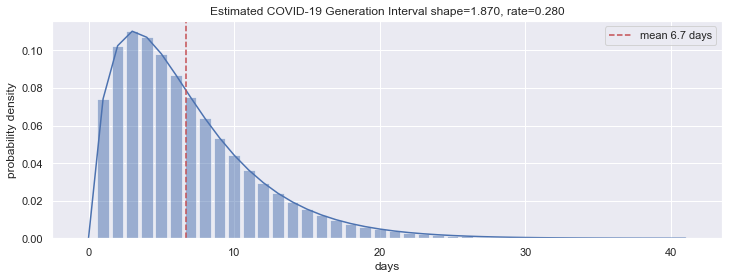

In [7]:
SI_x, SI_y, SI_mu, SI_sd = generation_time_gamma(ISS_sh, ISS_ra)

In [8]:
it = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
     usecols=['data', 'nuovi_positivi', 'totale_casi'],
     parse_dates=['data'],
     index_col=['data'],
     squeeze=True).sort_index()
it.index = it.index.normalize()

In [9]:
window = 14

In [32]:
modelString = """
model {
    tau_prior <- 1
    mu_prior ~ dnorm( 5 , 1/tau_prior^2 ) T(0,)
    sd_prior ~ dnorm( 5 , 1/tau_prior^2 ) T(0,)
    
    a_prior <- (mu_prior / sd_prior)^2    # shape
    b_prior <- (sd_prior^2) / mu_prior    # scale
    
    for ( t in 1:T ) {
        i_start[t] <- T - t + 1
        lambda[t] <- sum( SI_pmf[1:t] * incidence_rev[i_start[t]:T] )
    }
    
    for ( t in 1:D ) {
        incidence_sum[t] <- sum( incidence[t_start[t]:t_end[t]] )
        a_posterior[t] <- ifelse( t_end[t] > final_mean_si , a_prior + incidence_sum[t] , 0.01 )
        
        lambda_sum[t] <- sum( lambda[t_start[t]:t_end[t]] )
        b_posterior[t] <- ifelse( t_end[t] > final_mean_si , 1 / b_prior + lambda_sum[t] , 1 )
        
        confidence[t] ~ dgamma( a_posterior[t] , b_posterior[t] )
        no_results[t] ~ dgamma( 0.01 , 1 )
        
        R[t] <- ifelse( incidence_sum[t] > ignore_below , confidence[t] , no_results[t] )
    }
    
    R_pred_ml <- R[D]
    R_pred_hi[1] <- R[D]
    R_pred_lo[1] <- R[D]
    
    pred_incidence_ml[1] ~ dpois( sum( incidence[(T-6):T] ) / 7 )
    pred_incidence_lo[1] ~ dpois( sum( incidence[(T-6):T] ) / 7 )
    pred_incidence_hi[1] ~ dpois( sum( incidence[(T-6):T] ) / 7 )
    
    for ( p in 2:P ) {

        R_pred_hi[p] <- R_pred_ml + 0.33 * (p-1) / (P-1)
        R_pred_lo[p] <- R_pred_ml - 0.33 * (p-1) / (P-1)

        # most likely scenario
        y_prior_ml[p] ~ dnorm( pred_incidence_ml[p-1] , 1 / (pred_incidence_ml[p-1] / 100)^2 )  T(0,)
        lambda_pred_ml[p] <- y_prior_ml[p] * exp( 1 / gamma * ( R_pred_ml - 1 ) )
        pred_incidence_ml[p] ~ dpois( lambda_pred_ml[p] )
        
        # worst scenario
        y_prior_hi[p] ~ dnorm( pred_incidence_hi[p-1] , 1 / (pred_incidence_hi[p-1] / 100)^2 )  T(0,)
        lambda_pred_hi[p] <- y_prior_hi[p] * exp( 1 / gamma * ( R_pred_hi[p-1] - 1 ) )
        pred_incidence_hi[p] ~ dpois( lambda_pred_hi[p] )
        
        # best scenario
        y_prior_lo[p] ~ dnorm( pred_incidence_lo[p-1] , 1 / (pred_incidence_lo[p-1] / 100)^2 )  T(0,)
        lambda_pred_lo[p] <- y_prior_lo[p] * exp( 1 / gamma * ( R_pred_lo[p-1] - 1 ) )
        pred_incidence_lo[p] ~ dpois( lambda_pred_lo[p] )
    }
}
"""

In [30]:
def epi_estim_mcmc(model_data):

    jags_model = pyjags.Model(
        code=modelString, 
        data=model_data,
        chains=4, 
        adapt=adapt,
        progress_bar=False
    )

    jags_posteriors = jags_model.sample(
        warmup + sample, vars=['R', 
                               'pred_incidence_ml',
                               'pred_incidence_hi',
                               'pred_incidence_lo',
                              ]
    )
    return jags_posteriors

In [12]:
def plot_Rt(pyjags_data,
            dates,
            SI_mu, SI_sd,
            window,
            title='Italy'):

    summary = az.summary(pyjags_data, var_names="R", hdi_prob=.99, kind="stats")

    summary.index = dates  # obs_df.index[window+1:]

    ax = summary.plot(
        y='mean', color='w', alpha=.75, lw=1, figsize=(15, 5), ylim=(0, 5),
        label='Rt'
    )

    ax.fill_between(
        summary.index, 
        np.where(summary['hdi_99.5%']<1, summary['hdi_99.5%'], 1), 
        np.where(summary['hdi_0.5%']<1, summary['hdi_0.5%'], 1), 
        alpha=1, color='C2', label='lower than 1')

    ax.fill_between(
        summary.index, 
        np.where(summary['hdi_99.5%']>1, summary['hdi_99.5%'], 1), 
        np.where(summary['hdi_0.5%']>1, summary['hdi_0.5%'], 1), 
        alpha=1, color='C3', label='higher than 1')

    ax.set(
        title=f'{title} COVID-19: Rt estimation (EpiEstim MCMC method, window {window} days, '+\
              f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days) '+\
              f'C.I. 99%',
        ylim=(0, 4),
        xlim=(dates[0], dates[-1]),
        ylabel='Rt'
    )
    ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
    ax.legend(loc='upper right')

    ax.axhline(1, color='k', ls='-')
    plt.show()
    
    return summary

In [38]:
def plot_predictions(pyjags_data, 
                     SI_mu, 
                     date_0,
                     obs_df,
                     region='Italy'):

    summary = az.summary(pyjags_data, var_names="pred_incidence", filter_vars='regex', kind="stats")

    fig, ax = plt.subplots(figsize=(15, 4))

    for scenario, which in zip(['ml', 'hi', 'lo'], ['likely', 'worst', 'best']):

        sc = summary[summary.index.str.contains(scenario)].copy(deep=True)
        sc.index = pd.date_range(
            date_0, date_0 + pd.Timedelta(days=sc.index.size-1)
        )
        lo = sc['hdi_3%']
        hi = sc['hdi_97%']
        sc.plot(ax=ax, y='mean', label=f'{which} scenario')
        ax.fill_between(
            sc.index,
            lo, hi, alpha=.2
        )

    obs_df.iloc[-15:].plot(ax=ax, marker='o', color='k', label='observed')
    ax.plot(
        [obs_df.index[-7], obs_df.index[-1]],
        [obs_df.iloc[-7:].mean(), obs_df.iloc[-7:].mean()],
        color='b', label='7 days mean'
    )
    
    ylim = ax.get_ylim()
    ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
    ax.set(
        ylim=(0, ylim[-1]),
        title=f'{region} COVID-19: incidence prediction (Bettencourt-Ribeiro method, '+\
              f'$\gamma^{{-1}}={SI_mu:.1f}$ days) scenarios $R_t\pm0.33$',
        ylabel='new positive'
    )
    plt.show()

# ITALY

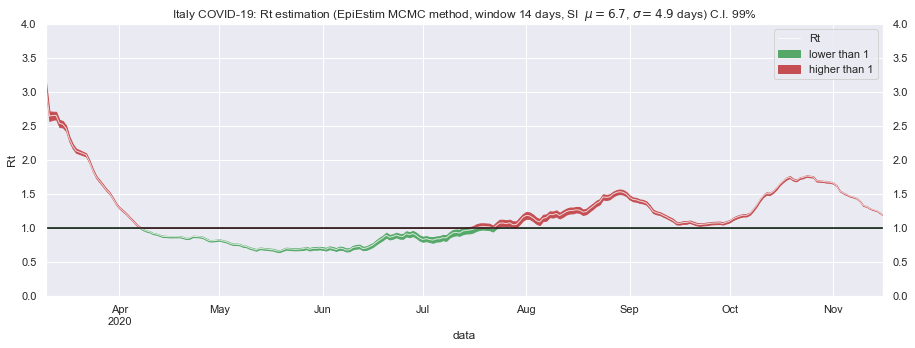

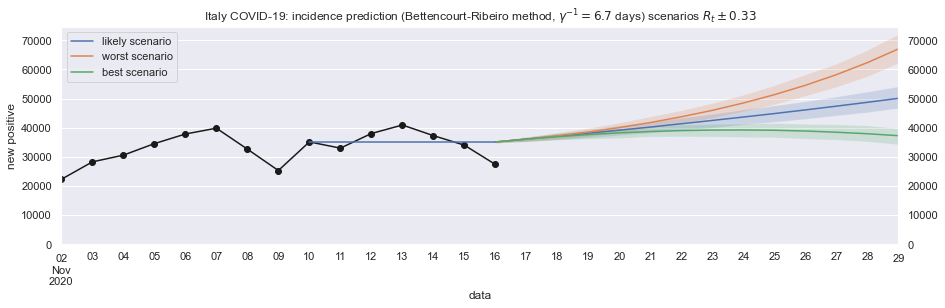

In [39]:
incidence = it.nuovi_positivi.values

# length of all observations
T = incidence.size
SI_tot = np.concatenate((SI_y, np.zeros(T - SI_y.size)))
final_mean_si = np.sum(
    SI_tot * np.arange(0, SI_tot.size, 1)
)

# start and end of posteriors
t_start = np.arange(1, T - window, 1)
t_end = t_start + window

model_data = {
    'T': T,
    'D': t_start.size,
    'incidence': it.nuovi_positivi.values,
    'incidence_rev': it.nuovi_positivi.values[::-1],
    't_start': t_start,
    't_end': t_end,
    'SI_pmf': SI_tot,
    'final_mean_si': final_mean_si,
    'P': window,
    'gamma': final_mean_si,
    'ignore_below': 50
}
post = epi_estim_mcmc(model_data)

pyjags_data = az.from_pyjags(post, warmup_iterations=warmup, save_warmup=False)

smry = plot_Rt(pyjags_data,
            it.index[window+1:],
            SI_mu, SI_sd,
            window,
            title='Italy')

plot_predictions(pyjags_data, 
                     SI_mu, 
                     it.index[-1],
                     it.nuovi_positivi,
                     region='Italy')

In [ ]:
Rt_italy_json = {
    'mean': smry['mean'].iloc[-1],
    'max': smry['hdi_99.5%'].iloc[-1],
    'min': smry['hdi_0.5%'].iloc[-1]
}
with open('Rt_italy.json', 'w') as f:
    json.dump(Rt_italy_json, f)

# REGIONS

In [15]:
def covid_regioni():
    df = pd.read_csv(
        "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
        parse_dates=['data'],
        index_col=['data'],
        squeeze=True).sort_index()
    df.index = df.index.normalize()
    return df

In [16]:
rg = covid_regioni()

## Abruzzo

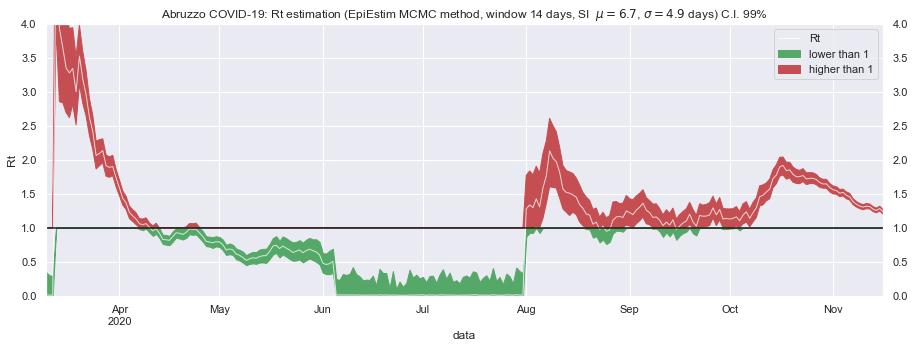

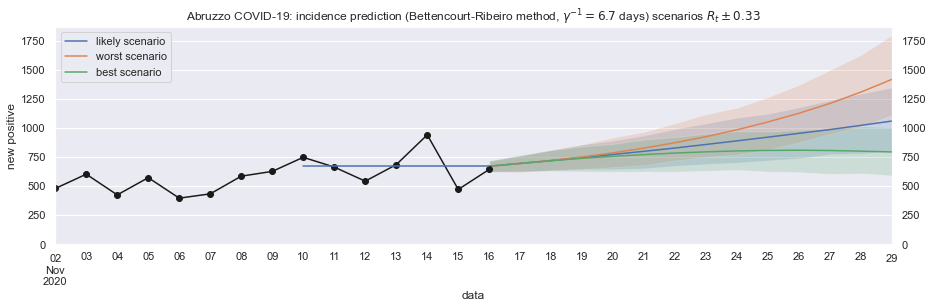

## Basilicata

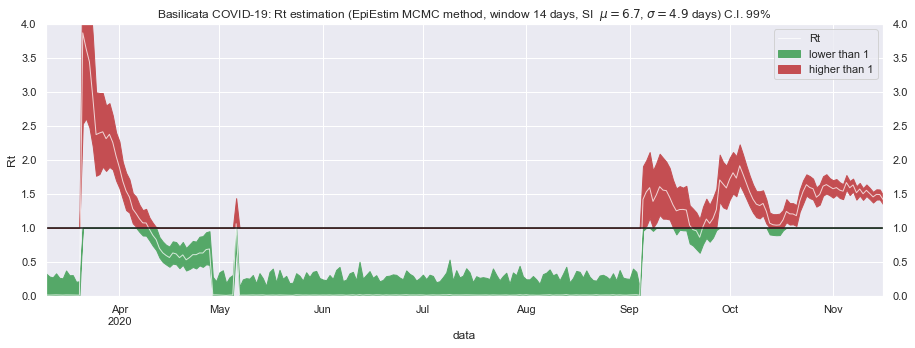

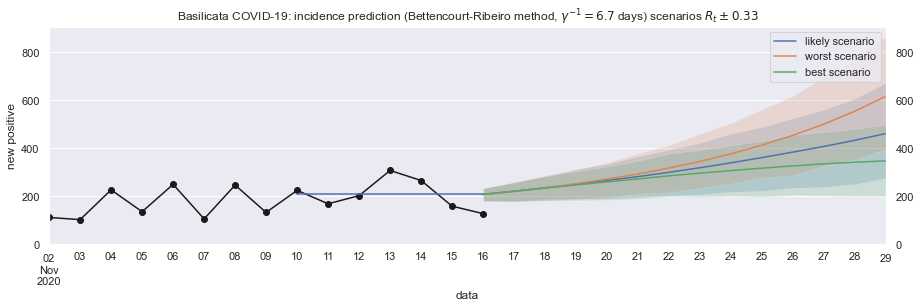

## Calabria

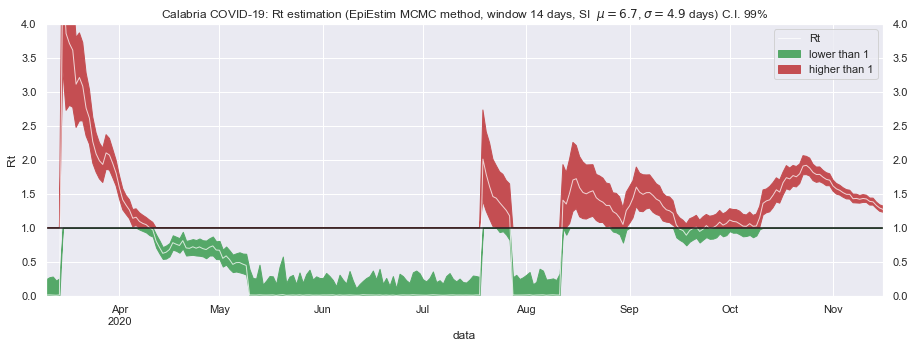

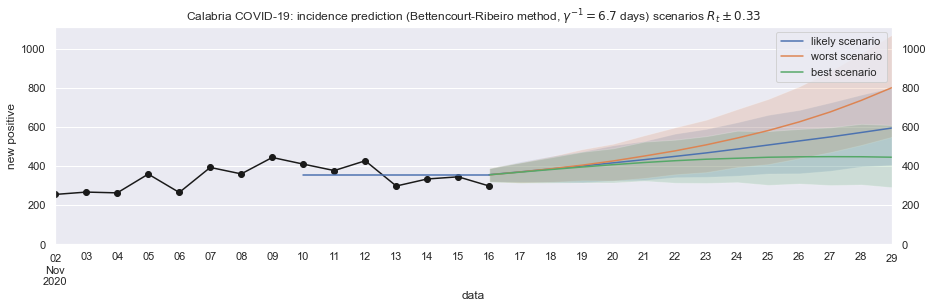

## Campania

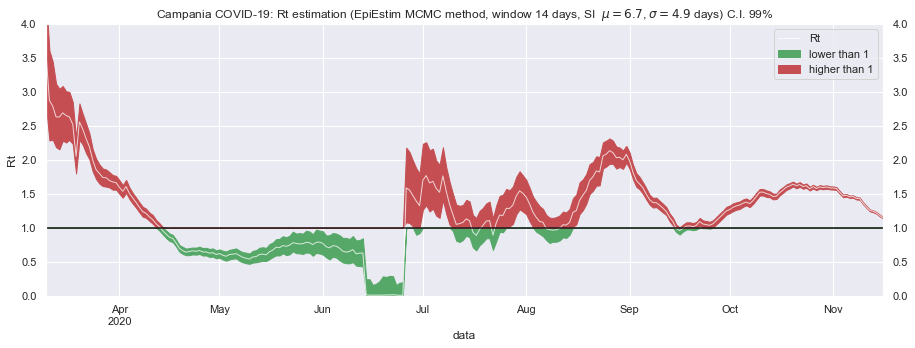

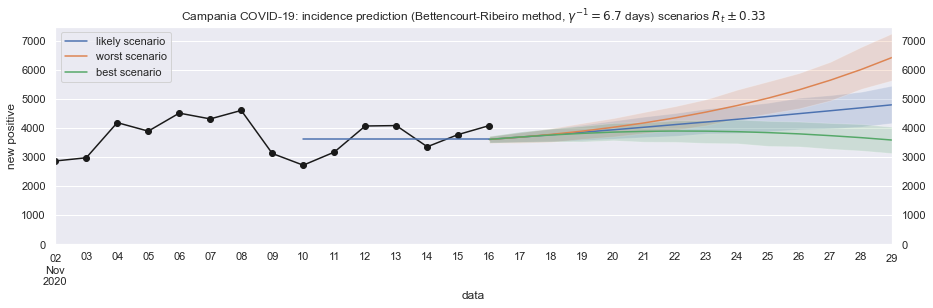

## Emilia-Romagna

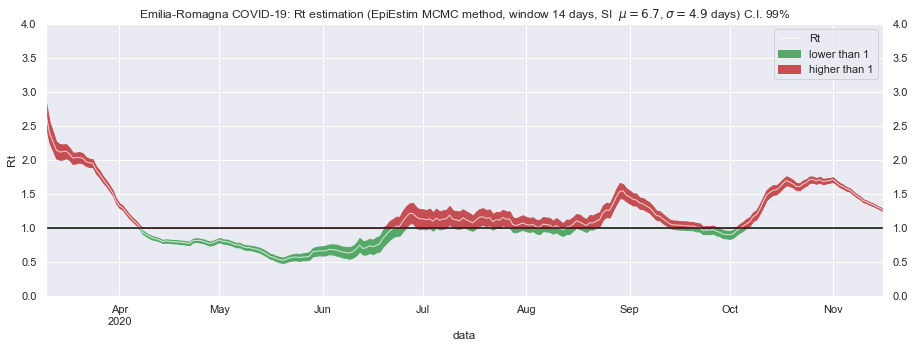

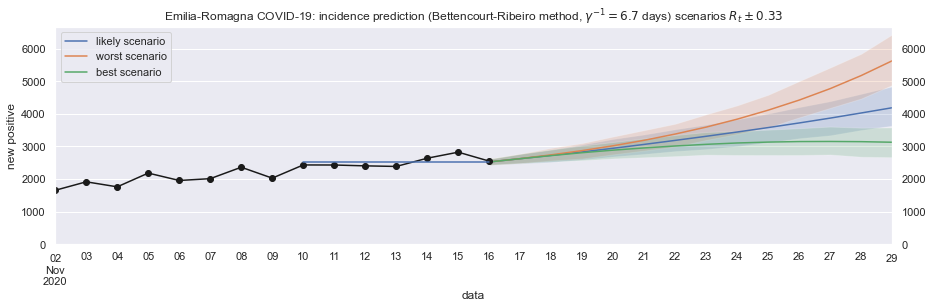

## Friuli Venezia Giulia

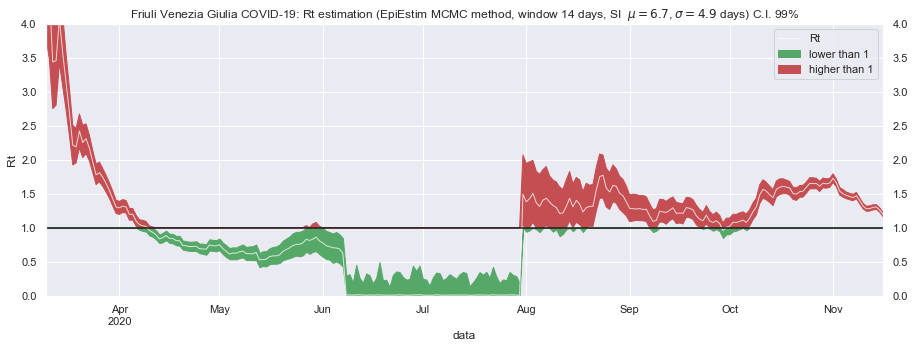

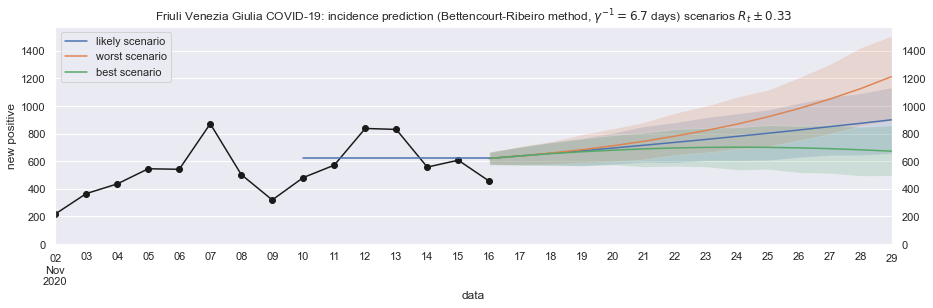

## Lazio

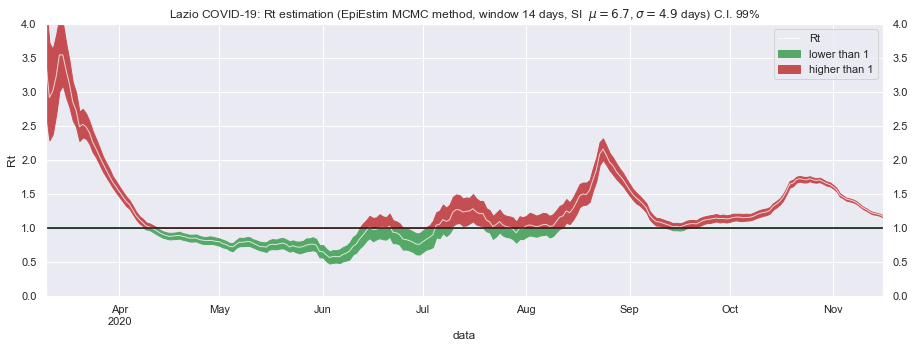

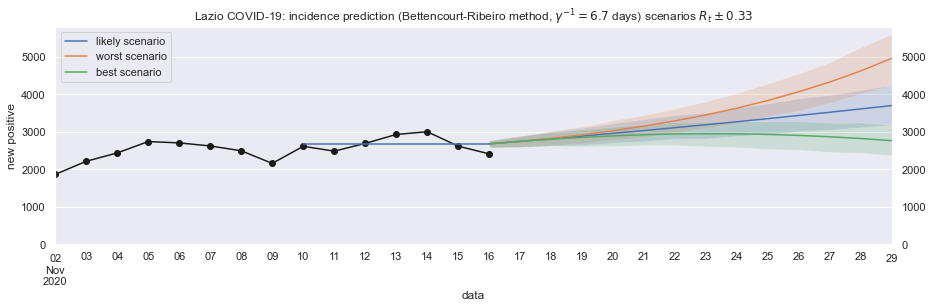

## Liguria

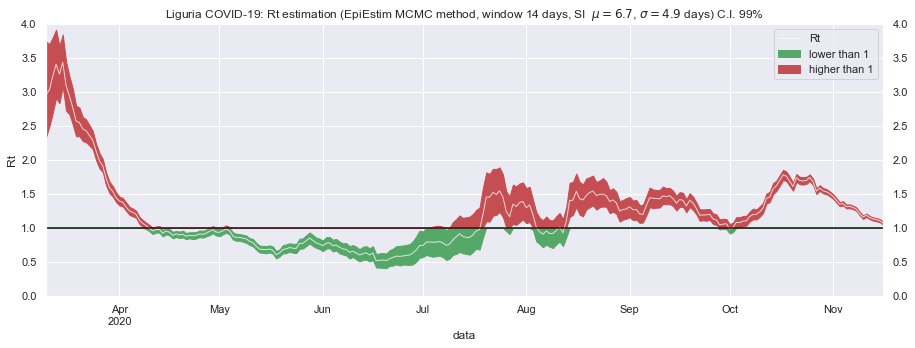

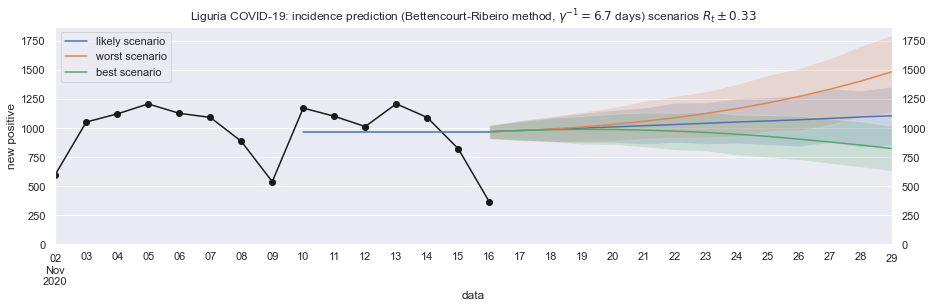

## Lombardia

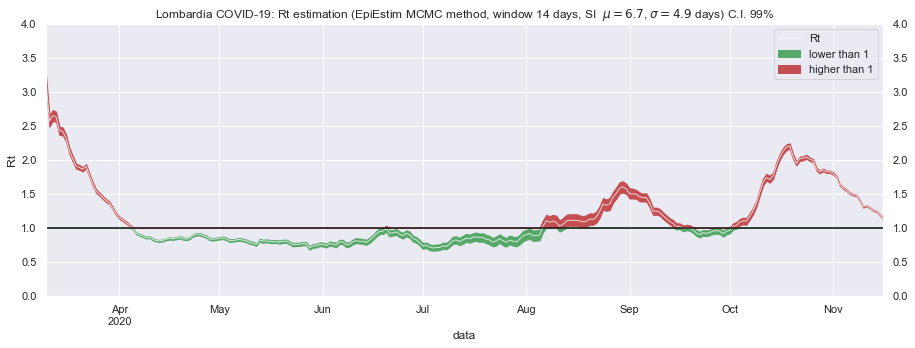

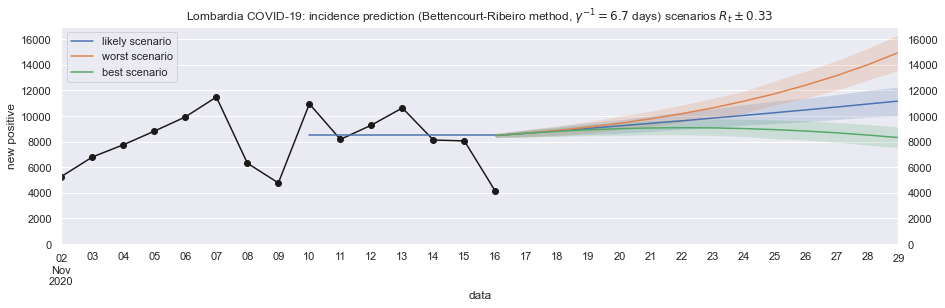

## Marche

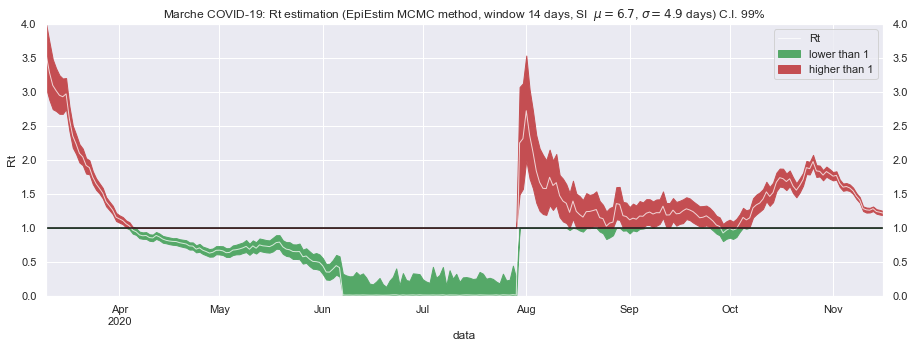

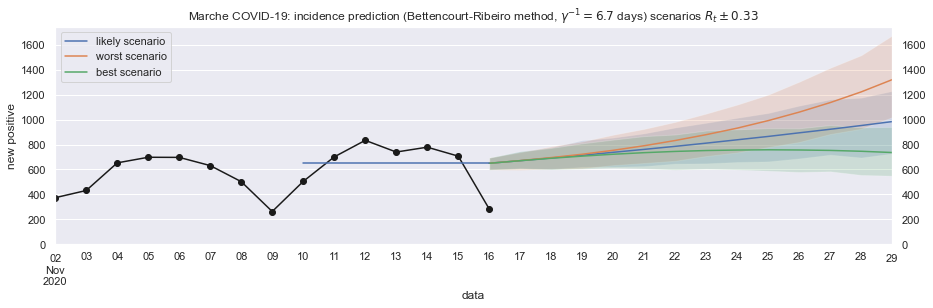

## Molise

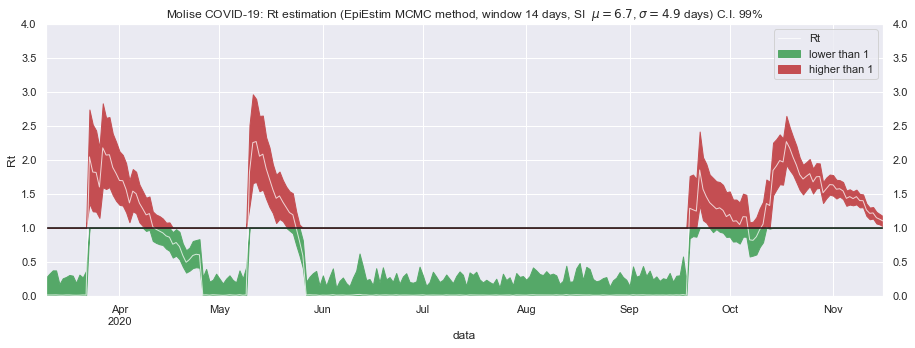

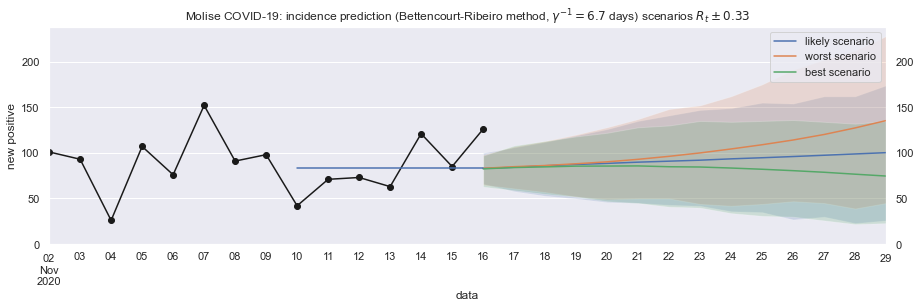

## P.A. Bolzano

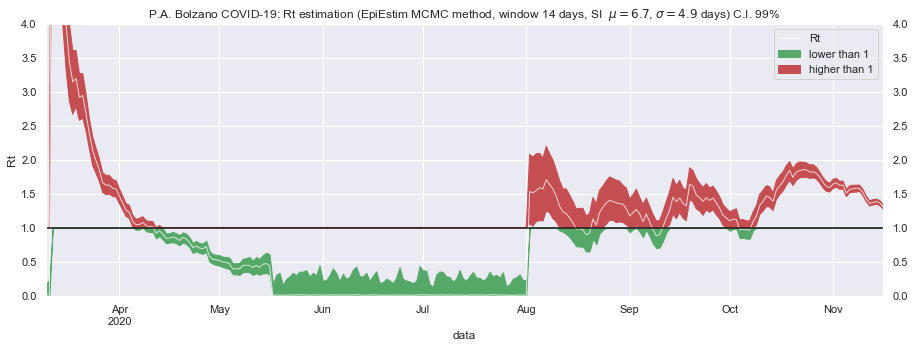

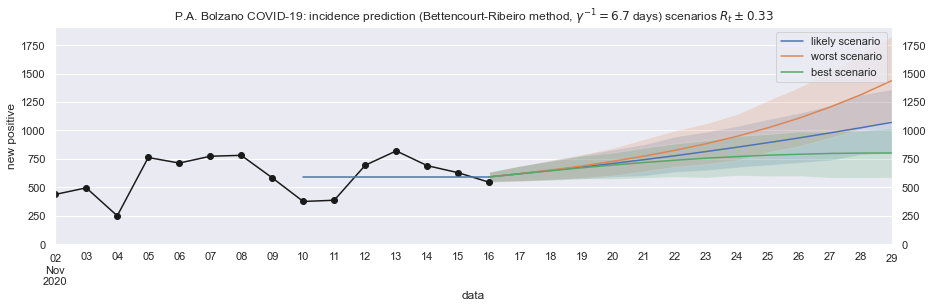

## P.A. Trento

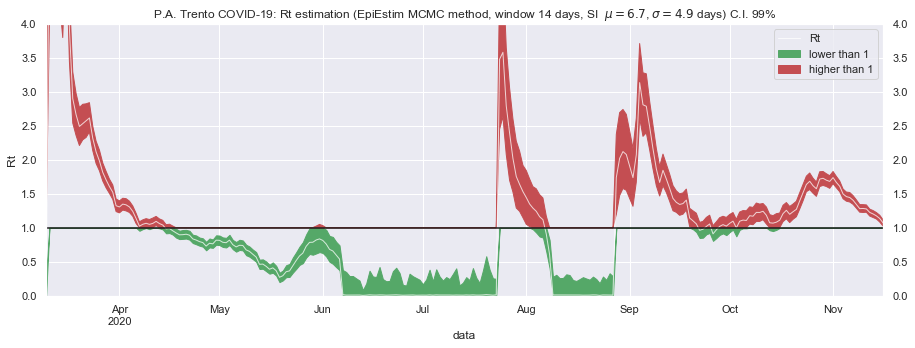

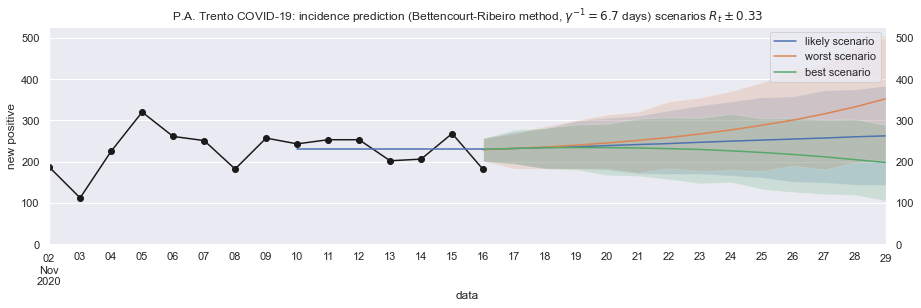

## Piemonte

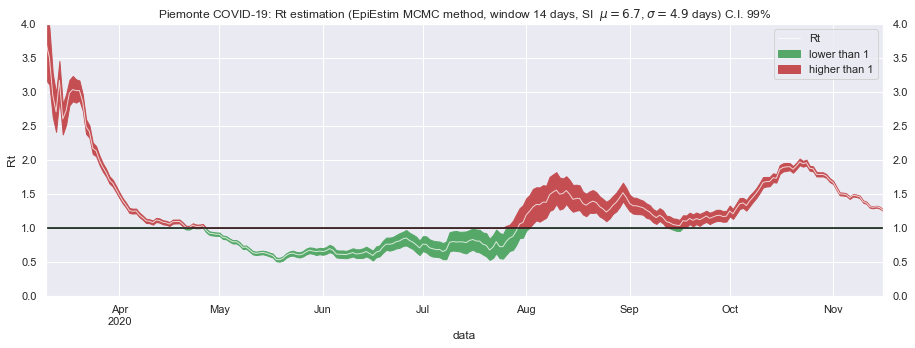

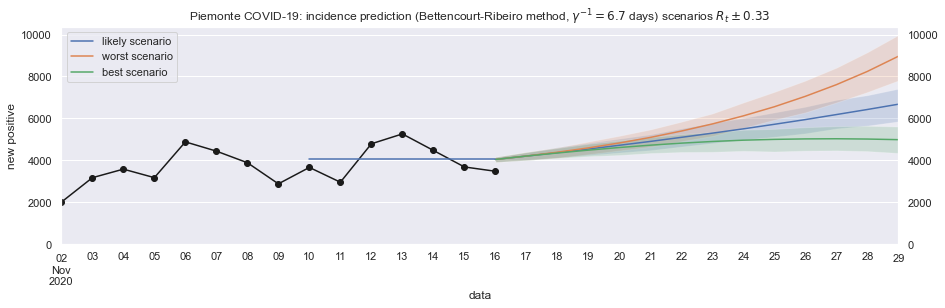

## Puglia

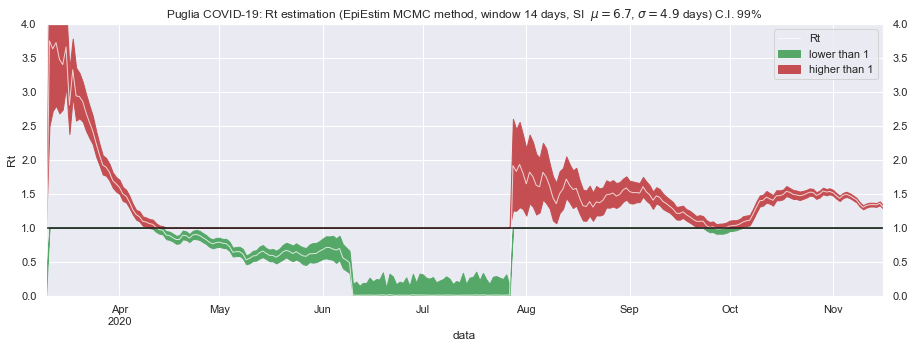

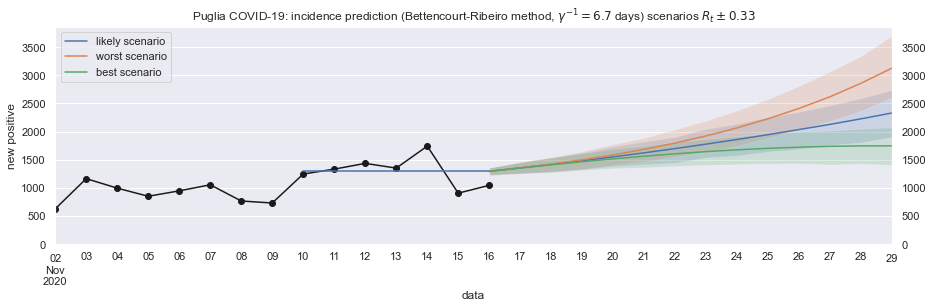

## Sardegna

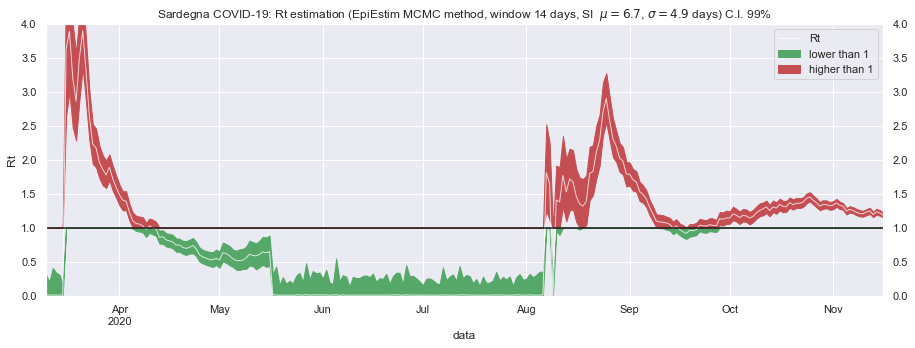

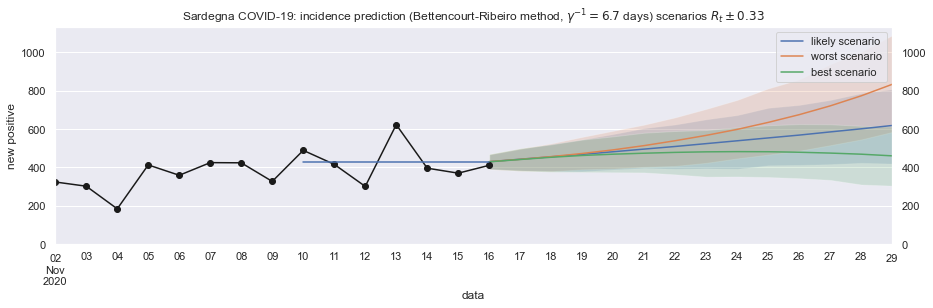

## Sicilia

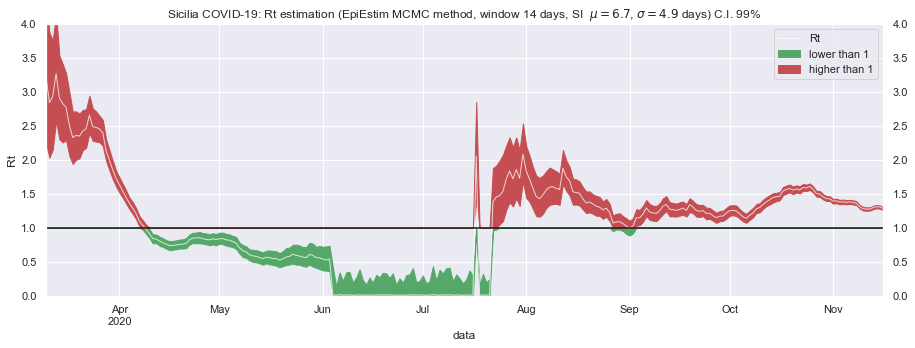

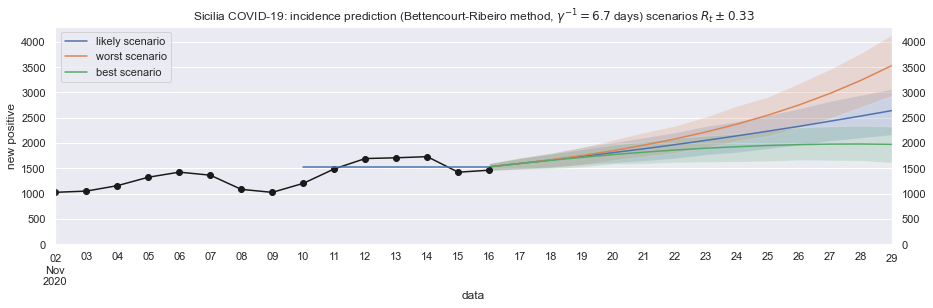

## Toscana

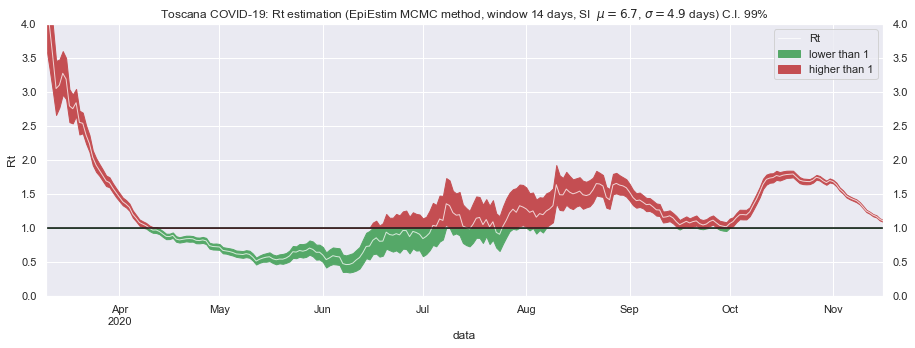

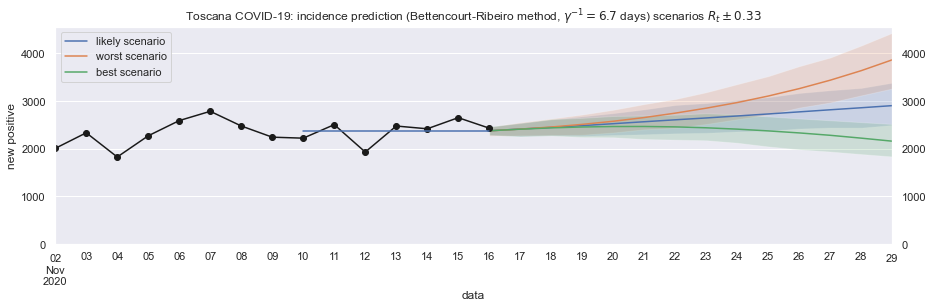

## Umbria

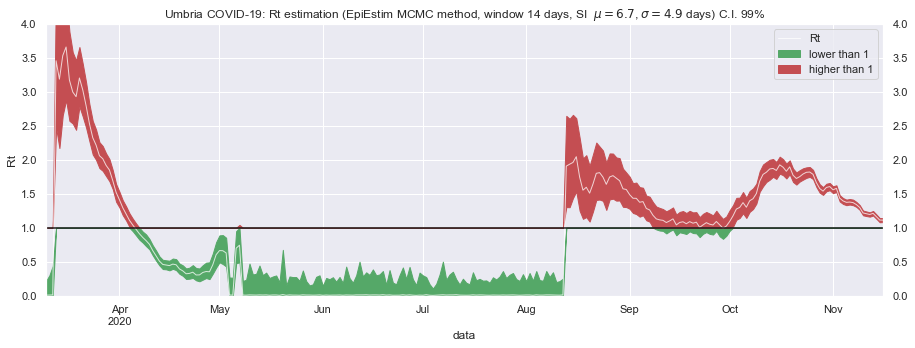

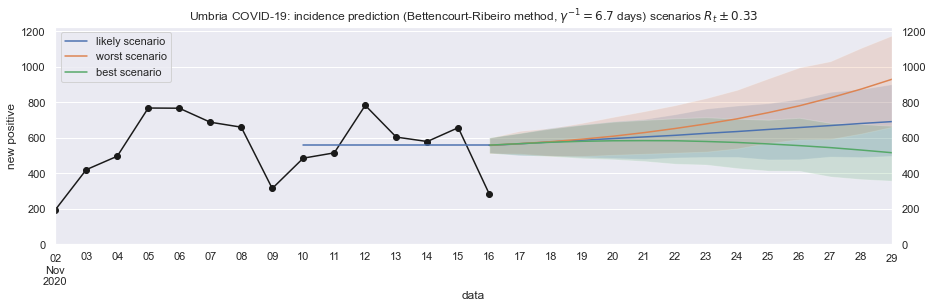

## Valle d'Aosta

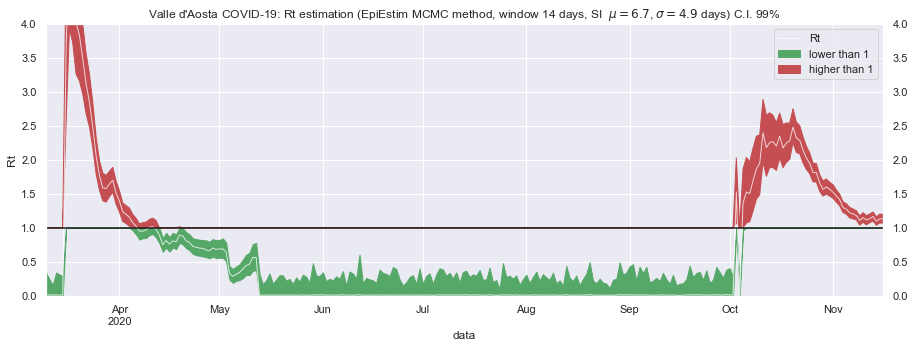

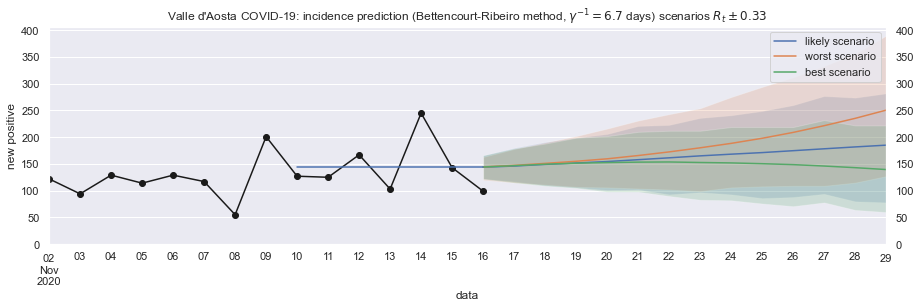

## Veneto

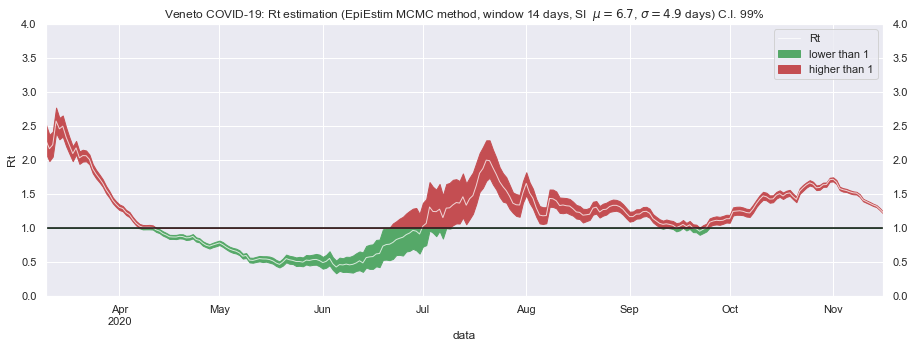

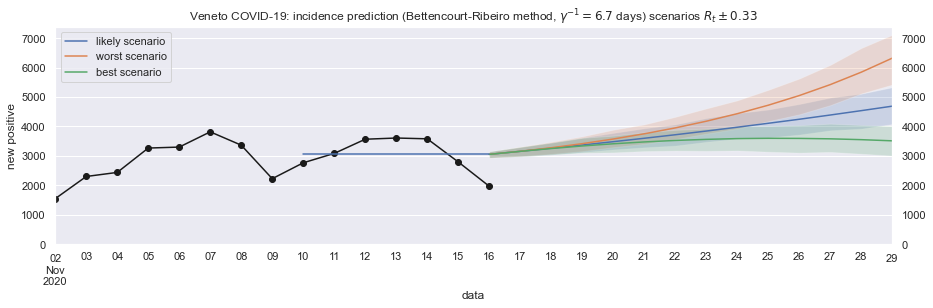

In [42]:
Rt_regioni_json = {}
Rt_latest_regions = {'region': [], 'mu': [], 'lo': [], 'hi': []}

for regione in rg.denominazione_regione.unique():
    
    display(Markdown(f"## {regione}"))

    _df = rg[rg.denominazione_regione==regione]
    T = _df.index.size
    
    original_incidence = _df.nuovi_positivi

    incidence = original_incidence.values
    incidence[incidence<0] = 0
    
    # length of all observations
    T = incidence.size
    SI_tot = np.concatenate((SI_y, np.zeros(T - SI_y.size)))
    final_mean_si = np.sum(
        SI_tot * np.arange(0, SI_tot.size, 1)
    )

    # start and end of posteriors
    t_start = np.arange(1, T - window, 1)
    t_end = t_start + window
    
    model_data = {
        'T': T,
        'D': t_start.size,
        'incidence': incidence,
        'incidence_rev': incidence[::-1],
        't_start': t_start,
        't_end': t_end,
        'SI_pmf': SI_tot,
        'final_mean_si': final_mean_si,
        'P': 14,
        'gamma': final_mean_si,
        'ignore_below': 50
    }
    post = epi_estim_mcmc(model_data)
    pyjags_data = az.from_pyjags(post, warmup_iterations=warmup, save_warmup=False)
    
    smry = plot_Rt(pyjags_data,
                _df.index[window+1:],
                SI_mu, SI_sd,
                window,
                title=regione)
    
    plot_predictions(pyjags_data, 
                         SI_mu, 
                         _df.index[-1],
                         original_incidence,
                         region=regione)
    
    Rt_latest_regions['region'].append(regione)
    Rt_latest_regions['mu'].append(smry['mean'].iloc[-1])
    Rt_latest_regions['lo'].append(smry['hdi_0.5%'].iloc[-1])
    Rt_latest_regions['hi'].append(smry['hdi_99.5%'].iloc[-1])
    
    Rt_regioni_json.update({region: smry['mean'].iloc[-1]})
    
with open('Rt_regioni.json', 'w') as f:
    json.dump(Rt_regioni_json, f)

# SUMMARY

In [18]:
Rt_latest_regions_df = pd.DataFrame(Rt_latest_regions)

In [19]:
Rt_latest_regions_df['greater_than_1'] = Rt_latest_regions_df.mu>1

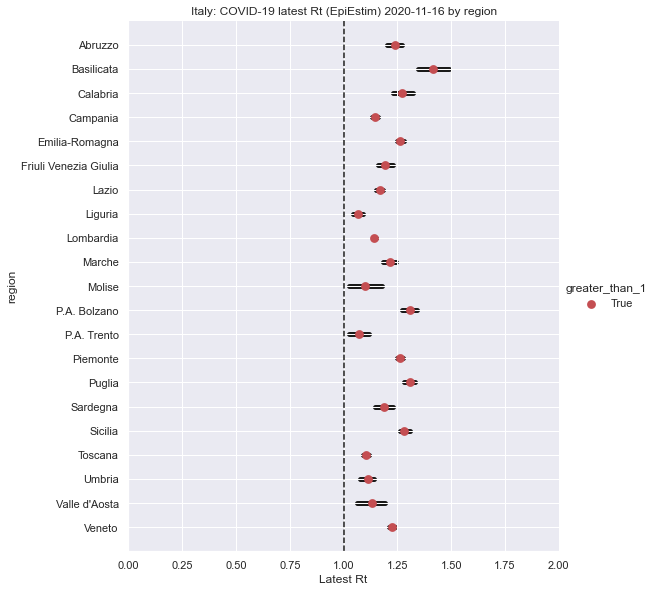

In [20]:
g = sns.catplot(
    data=Rt_latest_regions_df,
    kind='point',
    y='region', x='mu',
    hue='greater_than_1',
    palette=['C3', 'C2'],
    join=False,
    grid=True,
    height=8,
)
for regione in Rt_latest_regions_df.region:
    _df = Rt_latest_regions_df[Rt_latest_regions_df.region==regione]
    g.axes.flat[0].plot(
        [_df.lo, _df.hi], [regione, regione],
        color='k', lw=5,
        zorder=0
    )

g.axes.flat[0].axvline(1, color='k', ls='--')
    
g.axes.flat[0].set(
    xlim=(0, np.ceil(np.max(Rt_latest_regions_df.hi))),
    xlabel='Latest Rt',
    title=f'Italy: COVID-19 latest Rt (EpiEstim) {rg.index[-1].date()} by region'
)
g.axes.flat[0].grid(axis='y', color='w')

***

In [21]:
end = dt.datetime.now()
print(f"END: {end}")
print(f"Completed in {end - start}")

END: 2020-11-16 23:44:56.720544
Completed in 0:03:02.517909
